### Regional rainfall analysis: example over North-Pacific NW US coasts
- long-term rainfall linear trend (2001-2019. regridded GPM)
- long-term feature occurrence trend 
- extreme (99th) : conneting to super C-C?
- other areas suggested? focusing on where precip changes considerably over 2001-2019 <br>
(large-scale dynamics changes and how features responded to those) 

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from itertools import combinations

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%%time
# monthly mean from 6 hrly, 0.25 deg GPM dataset

data_precip_20yr = []

for year in np.arange(2001,2020):

    RGMA_DIR = Path('/neelin2020/RGMA_feature_mask/data_product/{}/MERGED_FP'.format(year))
    
    data_list = []

    for month in np.arange(1,13):
        
        file = list(RGMA_DIR.glob('*{}_expand.nc'.format(str(month).zfill(2))))[0]
    
        data = xr.open_dataset(file)
        data_precip_month_mn = data.precipitationCal.sel(time=data.time.dt.month.isin([month])).mean(dim='time')
        data_list.append(data_precip_month_mn)
    
    data_list = xr.concat(data_list, pd.Index(np.arange(1,13), name='month'))
    
    data_precip_20yr.append(data_list)
    
# monthly mean for each year (2001-2019)
data_precip_20yr = xr.concat(data_precip_20yr, pd.Index(np.arange(2001,2020), name='year'))

CPU times: user 46.7 s, sys: 58.2 s, total: 1min 44s
Wall time: 1min 45s


In [4]:
# targeted region: NW US coasts
data_precip_NWUS_20yr = data_precip_20yr.sel(longitude=slice(360-125,360-115), latitude=slice(30,50))

In [5]:
# stack time dimensions year, month into one 

data_precip_NWUS_20yr_stack = data_precip_NWUS_20yr.stack(time_stack=("year", "month"))
data_precip_NWUS_20yr_stack['time_stack'] = np.arange(len(data_precip_NWUS_20yr_stack.time_stack)) # set new coord
linreg_stats = data_precip_NWUS_20yr_stack.polyfit(dim='time_stack', deg=1)

In [6]:
precip_trend = linreg_stats.sel(degree=1).polyfit_coefficients

Text(0.5, 1.0, 'GPM P-Trend (2001-2019), 0.25-deg')

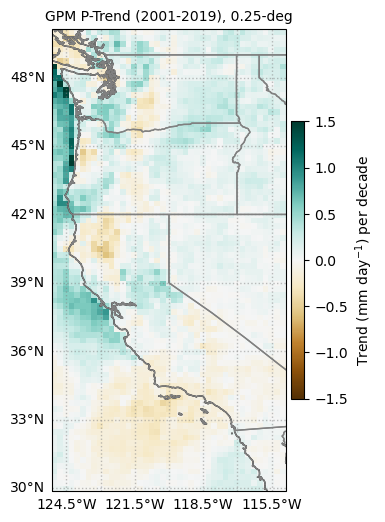

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6,6),subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(color='k')
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND
ax.add_feature(cfeat.STATES,edgecolor='gray')

# linear precipitation trend [(mm/day)/decade]
cf = ax.pcolor(precip_trend.longitude, precip_trend.latitude
                 , (120*24)*precip_trend, vmin=-1.5, vmax=1.5, cmap='BrBG')

cbar = plt.colorbar(cf, ax=ax, shrink=0.6, pad=0.01)
cbar.set_label('Trend (mm day$^{-1}$) per decade')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.5, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title('GPM P-Trend (2001-2019), 0.25-deg',fontsize=10)

In [8]:
%%time
### trend of probability of feature strikes (individual features)
data_feat_prob_20yr = []

for year in np.arange(2001,2020):

    print('year processed: {}'.format(year))
    
    RGMA_DIR = Path('/neelin2020/RGMA_feature_mask/data_product/{}/MERGED_FP'.format(year))
    
    data_list = []

    for month in np.arange(1,13):
        
        file = list(RGMA_DIR.glob('*{}_expand.nc'.format(str(month).zfill(2))))[0]
    
        # add front_a_tag: merge all fronts into one tag
        data = xr.open_dataset(file)
        tmp = data['front_c_tag'] + data['front_w_tag'] + data['front_s_tag']
        tmp = tmp.where(tmp == 0, 1)
        data['front_a_tag'] = tmp
        
        # selelct subdataset
        data_sub = data[['ar_tag','mcs_tag','lps_tag','front_a_tag']]
        
        data_feat_month_prob = data_sub.sel(time=data_sub.time.dt.month.isin([month])).mean(dim='time')
        data_list.append(data_feat_month_prob)
    
    data_list = xr.concat(data_list, pd.Index(np.arange(1,13), name='month'))
    
    data_feat_prob_20yr.append(data_list)
    
# feature occurrence probability for each year (2001-2019)
data_feat_prob_20yr = xr.concat(data_feat_prob_20yr, pd.Index(np.arange(2001,2020), name='year'))

year processed: 2001
year processed: 2002
year processed: 2003
year processed: 2004
year processed: 2005
year processed: 2006
year processed: 2007
year processed: 2008
year processed: 2009
year processed: 2010
year processed: 2011
year processed: 2012
year processed: 2013
year processed: 2014
year processed: 2015
year processed: 2016
year processed: 2017
year processed: 2018
year processed: 2019
CPU times: user 1min 29s, sys: 1min 59s, total: 3min 28s
Wall time: 3min 29s


In [9]:
# stack time dimensions year, month into one 

data_feat_prob_NWUS_20yr = data_feat_prob_20yr.sel(longitude=slice(360-125,360-115), latitude=slice(30,50))

data_feat_prob_NWUS_20yr_stack = data_feat_prob_NWUS_20yr.stack(time_stack=("year", "month"))
data_feat_prob_NWUS_20yr_stack = data_feat_prob_NWUS_20yr_stack.assign_coords(time_stack=("time_stack"
                                                             , np.arange(len(data_feat_prob_NWUS_20yr_stack.time_stack))))

linreg_stats = data_feat_prob_NWUS_20yr_stack.polyfit(dim='time_stack', deg=1)

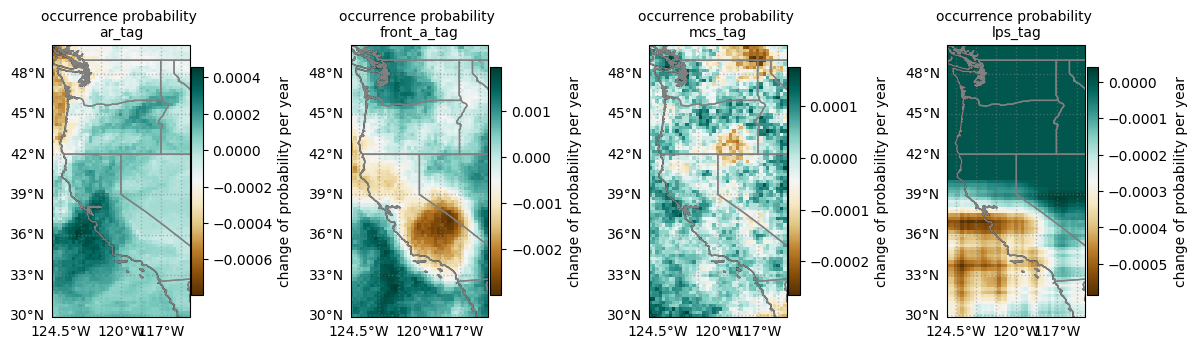

In [15]:
fig, ax = plt.subplots(1,4,figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})

for n, feat_tag in enumerate(['ar_tag','front_a_tag','mcs_tag','lps_tag']):

    ax[n].coastlines(color='k')
    ax[n].add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND
    ax[n].add_feature(cfeat.STATES,edgecolor='gray')

    var_name = feat_tag + '_polyfit_coefficients'
    
    feat_prob_trend = linreg_stats[var_name].sel(degree=1)
    
    # linear precipitation trend [(mm/day)/decade]
    cf = ax[n].pcolor(feat_prob_trend.longitude, feat_prob_trend.latitude
                     , (12)*feat_prob_trend, cmap='BrBG')

    cbar = plt.colorbar(cf, ax=ax[n], shrink=0.4, pad=0.01)
    cbar.set_label('change of probability per year')

    gl = ax[n].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='grey', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax[n].set_title('occurrence probability \n' + '{}'.format(feat_tag),fontsize=10)
    
plt.tight_layout()